# Bite Size Bayes

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Review

[In the previous notebook](https://colab.research.google.com/github/AllenDowney/BiteSizeBayes/blob/master/08_soccer.ipynb) I introduced the World Cup problem:

>In the 2018 FIFA World Cup final, France defeated Croatia 4 goals to 2.  Based on this outcome:
>
>1. How confident should we be that France is the better team?
>
>2. If the same teams played again, what is the chance Croatia would win?

I started with the assumption that for any team against any other team there is some unknown goal-scoring rate, λ.

And I showed that if we know λ, we can compute the probability of scoring $k$ goals in a game:

$f(k; λ) = λ^k exp(-λ) ~/~ k!$

This function is the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution), and we can use SciPy to compute it.

For example, if we know that λ is 1.4, we can compute the distribution of $k$ like this:


In [2]:
from scipy.stats import poisson

λ = 1.4
xs = np.arange(11)
ys = poisson.pmf(xs, λ)
pmf_goals = pd.Series(ys, index=xs)

pmf_goals

0     0.246597
1     0.345236
2     0.241665
3     0.112777
4     0.039472
5     0.011052
6     0.002579
7     0.000516
8     0.000090
9     0.000014
10    0.000002
dtype: float64

In theory, the values of $k$ go to infinity, but I cut it off at 10 because higher values have very low probability.

Here's what the distribution of $k$ looks like:

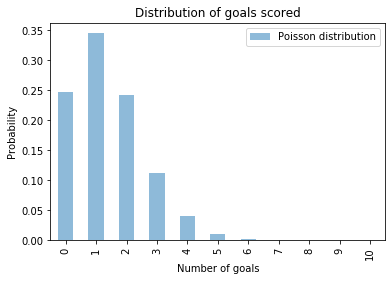

In [24]:
pmf_goals.plot.bar(color='C0', alpha=0.5, label='Poisson distribution')

plt.xlabel('Number of goals')
plt.ylabel('Probability')
plt.title('Distribution of goals scored')
plt.legend();

Because the values of $k$ are discrete integers, I use a bar chart to plot the distribution.

Next I used a gamma distributon to represent the prior distribution of λ.  I set the parameter of the gamma distribution, α, to 1.4, which is the average number of goals each team score in World Cup play.

I broke the range of values for λ into 101 discrete possibilities and used SciPy to compute the prior probabilities:

In [25]:
from scipy.stats import gamma

α = 1.4
qs = np.linspace(0, 10, 101)
ps = gamma.pdf(qs, α)

prior = pd.Series(ps, index=qs)
prior /= prior.sum()

Here's what the prior distribution looks like:

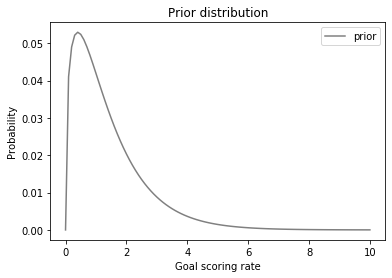

In [26]:
prior.plot(label='prior', color='gray')

plt.xlabel('Goal scoring rate')
plt.ylabel('Probability')
plt.title('Prior distribution')
plt.legend();

Because the values of $λ$ are continuous, I use a line chart to plot the distribution.

Next we did a Bayesian update, using the Poisson distribution to compute the likelihood of the data, $k$, for each possible goal scoring rate, $λ$

$ f(k; λ) = λ^k \exp(-λ) ~/~ k! $

Since France scored 4 goals, the likelihood of the data is:

In [27]:
λs = prior.index
k = 4
likelihood = poisson.pmf(k, λs)

And we can use the following function to do the update:

In [28]:
def bayes_update(pmf, likelihood):
    """Do a Bayesian update.
    
    pmf: Series that represents the prior
    likelihood: sequence of likelihoods
    
    returns: float probability of the data
    """
    pmf *= likelihood
    prob_data = pmf.sum()
    pmf /= prob_data
    return prob_data

In [29]:
france = prior.copy()
bayes_update(france, likelihood)

0.05015532557804499

And we can do the same thing for Croatia, given that they scored 2 goals:

In [30]:
k = 2
λs = prior.index
likelihood = poisson.pmf(k, λs)

croatia = prior.copy()
bayes_update(croatia, likelihood)

0.1609321178598705

Here's what the results look like.

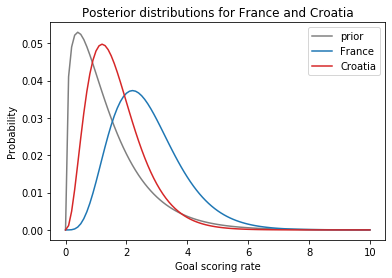

In [31]:
prior.plot(label='prior', color='gray')
france.plot(label='France', color='C0')
croatia.plot(label='Croatia', color='C3')

plt.xlabel('Goal scoring rate')
plt.ylabel('Probability')
plt.title('Posterior distributions for France and Croatia')
plt.legend();

In the previous notebook, I introduces this function, which computes the mean of a PMF.

In [11]:
def pmf_mean(pmf):
    """Compute the mean of a PMF.
    
    pmf: Series representing a PMF
    
    return: float
    """
    return np.sum(pmf.index * pmf)

We can use it to compute the posterior means for France and Croatia.

In [12]:
pmf_mean(france), pmf_mean(croatia)

(2.699772393342308, 1.6999765866755225)

Based on the outcome of the game, we have some reason to think France is the better team.

But if we look at the posterior distribution of λ for France and Croatia, there is still a lot of overlap, which means we are still not certain which is the better team.

In the next section, we'll use the posterior distributions to compute the "probability of superiority".

### Probability of superiority

Now that we have a posterior distribution for each team, we can answer the first question: How confident should we be that France is the better team?

In the model, "better" means having a higher goal-scoring rate against the opponent.  We can use the posterior distributions to compute the probability that a random value drawn from France's distribution exceeds a value drawn from Croatia's.

The following function takes a Series that represents a PMF and draws a sample from it.

In [13]:
def pmf_choice(pmf, n):
    """Draw a random sample from a PMF.
    
    pmf: Series representing a PMF
    n: number of values to draw
    
    returns: NumPy array
    """
    return np.random.choice(pmf.index,
                            size=n, 
                            replace=True, 
                            p=pmf)

`pmf_choice` uses `np.random.choice`, which chooses `n` values from the PMF with replacement, so the same value can appear more than once.  It uses the probabilities from the PMF as weights, so the number of times each value appears is proportional to its probability.

Here's a sample from the posterior distribution for France.

In [14]:
sample_france = pmf_choice(france, 1000)
sample_france.mean()

2.6139

And here's a sample for Croatia.

In [15]:
# Solution

sample_croatia = pmf_choice(croatia, 1000)
sample_croatia.mean()

1.6958

To estimate the probability of superiority, we can count the number of times the value from France's distribution exceeds the value from Croatia's distribution.

In [16]:
# Solution

np.mean(sample_france > sample_croatia)

0.733

On the basis of one game, we have moderate confidence that France is actually the better team.

### Predicting the rematch

Now we can take on the second question: If the same teams played again, what is the chance Croatia would win?

To answer this question, we'll generate a sample from the "posterior predictive distribution", which is the number of goals we expect a team to score.

If we knew the goal scoring rate, λ, the distribution of goals would be a Poisson distributon with parameter λ.

Since we don't know λ, we can use the sample we generated in the previous section to generate a sample of goals, like this:

In [17]:
goals_france = np.random.poisson(sample_france)

`np.random.poisson` uses each element of `sample_france` to generate a random value; that is, each value in the result is based on a different value of λ.

To see what the resulting distribution looks like, we'll use this function from a previous notebook:

In [18]:
def pmf_from_seq(seq):
    """Make a PMF from a sequence of values.
    
    seq: sequence
    
    returns: Series representing a PMF
    """
    pmf = pd.Series(seq).value_counts(sort=False).sort_index()
    pmf /= pmf.sum()
    return pmf

2.559

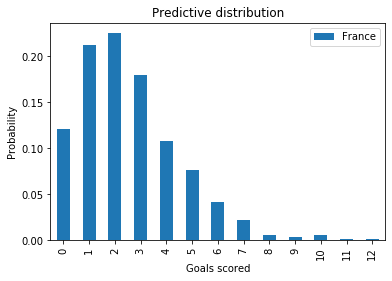

In [19]:
pmf_france = pmf_from_seq(goals_france)
pmf_france.plot.bar(color='C0', label='France')

plt.xlabel('Goals scored')
plt.ylabel('Probability')
plt.title('Predictive distribution')
plt.legend()

goals_france.mean()

This distribution represents two sources of uncertainty: we don't know the actual value of λ, and even if we did, we would not know the number of goals in the next game.

**Exercise:** Generate and plot the predictive distribution for Croatia.

1.786

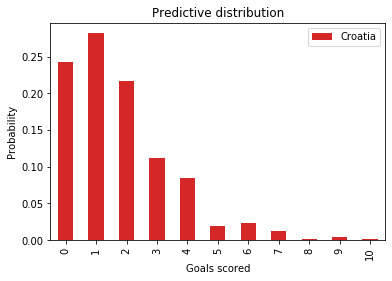

In [20]:
# Solution

goals_croatia = np.random.poisson(sample_croatia)

pmf_croatia = pmf_from_seq(goals_croatia)
pmf_croatia.plot.bar(label='Croatia', color='C3')

plt.xlabel('Goals scored')
plt.ylabel('Probability')
plt.title('Predictive distribution')
plt.legend()

goals_croatia.mean()

In a sense, these distributions represent the outcomes of 1000 simulated games.

**Exercise:** Compute the fraction of simulated rematches Croatia would win, how many France would win, and how many would end in a tie.

In [21]:
# Solution

np.mean(goals_croatia > goals_france)

0.28

In [22]:
# Solution

np.mean(goals_france > goals_croatia)

0.549

In [23]:
# Solution

np.mean(goals_france == goals_croatia)

0.171

Assuming that Croatia wins half of the ties, their chance of winning the rematch is about 33%.